In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [85]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler()
    }

param_grid = {
    'module__num_hidden' : [5, 10, 15],
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [64, 128, 512]
}

# Data Prep

In [86]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [87]:
df = pd.read_excel('wide_range.xlsx')

In [88]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [89]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [90]:
# scale for training
scaler = RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [91]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [92]:
# add noise
X_noisy = add_noise(X, args['noise'])

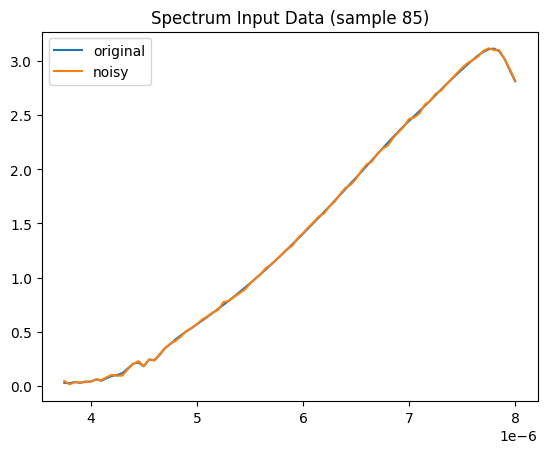

In [93]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [94]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [96]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train.values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test.values, dtype=torch.float32)

    layer['y'] = torch.tensor(y[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [97]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

In [98]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        self.num_hidden = num_hidden
        self.criterion = nn.L1Loss()

        hidden_sizes = [input_size]
        step = input_size / (self.num_hidden+1)

        for i in range(self.num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(self.num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x
    


In [99]:
input_size = len(X.columns)
output_size = 1

In [100]:
for layer in layers:
    print("{} gridsearch".format(layer['col']))
    net = NeuralNetRegressor(
        module=FeedForward,
        module__input_size=input_size, 
        module__output_size=output_size,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, refit=True)

    gs.fit(X_tensor, layer['y'])

    best_model = gs.best_estimator_
    best_params = gs.best_params_

    layer['model'] = best_model
    
    print(best_params)
    print('\n')

layer 1 gridsearch
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   115200.6716    23473.6912  0.1135
      2    20530.3319    18804.5897  0.1206
      3    17038.1947    13877.4156  0.1169
      4    11201.1714     8220.6644  0.1301
      5     5327.6600     1281.9437  0.1178
      6      705.3083      323.6950  0.1169
      7      329.0014      293.2528  0.1250
      8      314.8678      284.3790  0.1213
      9      304.4420      270.0982  0.1211
     10      286.3903      248.6363  0.1153
     11      258.4829      224.5191  0.1115
     12      237.6874      210.6741  0.1001
     13      224.1453      189.3552  0.1093
     14      200.0057      169.8381  0.1307
     15      172.7008      145.8343  0.1395
     16      151.8491      133.2458  0.1399
     17      141.8649      129.5426  0.1227
     18      138.3884      128.7133  0.1229
     19      136.9217      128.3378  0.1112
     20      136.1622      128.2398  0.1153
     21      

In [101]:
test_losses = []
test_criterion = nn.L1Loss()

for layer in layers:
    features = layer['X_test']
    target = layer['y_test']
    net = layer['model']

    with torch.no_grad():
        pred = net(features)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

TypeError: 'NeuralNetRegressor' object is not callable

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)